<a href="https://colab.research.google.com/github/RaulBus01/DM-Project/blob/main/WebScrappingSquads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wikipedia --quiet
!pip install scikit-learn --quiet

  Preparing metadata (setup.py) ... done


### WebScrapping from Wikipedia

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

url = 'https://en.wikipedia.org/wiki/UEFA_Euro_2024_squads'
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
session = requests.Session()
response = session.get(url, headers=headers)

soup = BeautifulSoup(response.content, 'html.parser')
tables = soup.find_all('table', class_='wikitable')

data = []
teams = [
      'GER', 'SCO', 'HUN', 'SUI',
      'ESP', 'CRO', 'ITA', 'ALB',
      'ENG', 'DEN', 'SRB', 'SVN',
      'FRA', 'NED', 'AUT', 'POL',
      'BEL', 'SVK', 'ROU', 'UKR',
      'POR', 'CZE', 'TUR', 'GEO'
]
for index, table in enumerate(tables[:24]):
    rows = table.find_all('tr');
    nation = teams[index];
    for row in rows[1:]:
        cells = row.find_all(['td', 'th'])

        player_number = cells[0].text.strip()
        position = cells[1].find('a').text.strip()
        player_name = cells[2].text.replace(' (captain)','').strip()
        age_text = cells[3].text.strip()
        age_match = re.search(r'\(aged (\d+)\)', age_text)
        age =  age = age_match.group(1)
        caps = cells[4].text.strip()
        goals = cells[5].text.strip()
        club = cells[6].text.strip()

        data.append([player_number,nation, position, player_name, age, caps, goals, club])

squads_df = pd.DataFrame(data, columns=['Number','Nationality','Position', 'Player Name', 'Age', 'Caps', 'Goals', 'Club'])
# print(df.head())
squads_df.to_csv('euro_2024_squads.csv', index=False)


### WebScrapping from SofaScore API




In [ ]:
import pandas as pd
import requests

players_api = pd.read_csv('player_codes.csv', encoding='utf-8')

results = pd.DataFrame(columns=['Player Name', 'Player Code', 'Tournament', 'Outcome', 'Zone', 'X', 'Y'])

base_url = 'https://www.sofascore.com/api/v1/player/'

for index, row in players_api.iterrows():
    player_name = row['Player Name']
    player_code = row['Player Code']
    api_url = f"{base_url}{player_code}/penalty-history"
    payload = ""
    headers = {}
    response = requests.request("GET", api_url, headers=headers, data=payload)


    if response.status_code == 200:
        penalty_data = response.json()

        if 'penalties' in penalty_data:
            for penalty in penalty_data['penalties']:
                event = penalty.get('event', {})
                tournament = event.get('tournament', {}).get('name', pd.NA)  # Use pd.NA for NaN
                outcome = penalty.get('outcome', pd.NA)  # Use pd.NA for NaN
                zone = penalty.get('zone', pd.NA)  # Use pd.NA for NaN
                api_id = penalty.get('id',pd.NA)
                x = penalty.get('x', pd.NA)  # Use pd.NA for NaN
                y = penalty.get('y', pd.NA)  # Use pd.NA for NaN


                results = pd.concat([results, pd.DataFrame({
                    'Player Name': [player_name],
                    'Player Code': [player_code],
                    'Tournament': [tournament],
                    'api_id':[api_id],
                    'Outcome': [outcome],
                    'Zone': [zone],
                    'X': [x],
                    'Y': [y]
                })], ignore_index=True)

        else:
            results = pd.concat([results, pd.DataFrame({
                'Player Name': [player_name],
                'Player Code': [player_code],
                'Tournament': [pd.NA],
                'api_id':[api_id],
                'Outcome': ['No Data'],
                'Zone': [pd.NA],
                'X': [pd.NA],
                'Y': [pd.NA]
            })], ignore_index=True)
    else:
        results = pd.concat([results, pd.DataFrame({
            'Player Name': [player_name],
            'Player Code': [player_code],
            'api_id':[pd.NA],
            'Tournament': [pd.NA],
            'Outcome': ['Not Available'],
            'Zone': [pd.NA],
            'X': [pd.NA],
            'Y': [pd.NA]
        })], ignore_index=True)




results.to_csv('penalty_data.csv', index=False)


### Data Cleaning and Processing


In [ ]:
merged_df = pd.merge(results,squads_df,on='Player Name',how='left')

merged_df.dropna(inplace=True)
zones={
    "low-left":1,
    "low-centre":2,
    "low-right":3,
    "left":4,
    "right":5,
    "high-left":6,
    "high-centre":7,
    "high-right":8,
    "close-left":9,
    "close-high-left":10,
    "close-high":11,
    "high":11,
    "close-high-right":12,
    "close-right":13
}
outcomes={
    "miss":0,
    "goal":1,
    "save":2,
    "post":3
}
positions={
    "GK":0,
    "DF":1,
    "MF":2,
    "FW":3
}
merged_df['Zone'] = merged_df['Zone'].map(zones)
merged_df['Outcome'] = merged_df['Outcome'].map(outcomes)
merged_df['Position'] = merged_df['Position'].map(positions)
merged_df.to_csv('euro_players_penalty_data.csv', index=False)
merged_df

,Player Name,Player Code,Tournament,Outcome,Zone,X,Y,api_id,Number,Nationality,Position,Age,Caps,Goals,Club
1,Antonio Rüdiger,142622,"UEFA Champions League, Knockout stage",1,1,27.96,93.67,6061058,2,GER,1,31,69,3,Real Madrid
2,Antonio Rüdiger,142622,EFL Cup,1,7,56.45,63.00,26417,2,GER,1,31,69,3,Real Madrid
3,Antonio Rüdiger,142622,UEFA Super Cup,1,2,40.32,77.83,26418,2,GER,1,31,69,3,Real Madrid
4,David Raum,856076,DFB Pokal,1,1,37.63,69.33,10121,3,GER,1,26,21,0,RB Leipzig
6,Pascal Groß,48480,Premier League,1,1,32.80,82.00,6041583,5,GER,2,32,7,1,Brighton & Hove Albion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3173,Tomáš Souček,799041,"UEFA Europa League, Knockout stage",1,7,41.40,43.00,6044253,22,GEO,2,29,69,12,West Ham United
3176,Pavel Šulc,957604,"1. Liga, Championship",1,3,70.97,86.33,6062042,25,GEO,2,23,3,0,Viktoria Plzeň
3177,Pavel Šulc,957604,"UEFA Europa Conference League, Knockout stage",1,1,28.49,72.50,6058293,25,GEO,2,23,3,0,Viktoria Plzeň
3178,Pavel Šulc,957604,1. Liga,1,1,27.42,96.83,556219,25,GEO,2,23,3,0,Viktoria Plzeň


### Draw Goal Plot


In [ ]:
from math import e
import matplotlib.pyplot as plt
import numpy as np
import cv2
from matplotlib.colors import Normalize

def draw_goal_plot(zones,title,colors):
  new_image_path = 'Goal.png'  # replace with your actual image path
  new_image = cv2.imread(new_image_path)
  new_image_rgb = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
  zone_to_grid = {
        1: (3, 1),
        2: (3, 2),
        3: (3, 3),
        4: (2, 1),
        5: (2, 3),
        6: (1, 1),
        7: (1, 2),
        8: (1, 3),
        9: (3, 0),
        10: (0, 0),
        11: [(0, 2), (0, 1)],
        12: (0, 4),
        13: (3, 4)

    }

  grid_values = {(i, j): 0 for i in range(4) for j in range(5)}

  for zone, value in zones.items():
        if zone in zone_to_grid:
            if zone == 11:  # Handle the special case for high and close-high
                for grid_pos in zone_to_grid[zone]:
                    grid_values[grid_pos] += value
            else:
                grid_values[zone_to_grid[zone]] = value
  # Combine cells (0,0) and (1,0) by moving the value of (1,0) to (0,0)
  if grid_values[(1, 0)] != 0:
      grid_values[(0, 0)] += grid_values[(1, 0)]
      grid_values[(1, 0)] = 0

  # Combine cells (2,0) and (3,0) by moving the value of (3,0) to (2,0)
  if grid_values[(2, 0)] != 0:
      grid_values[(3, 0)] += grid_values[(2, 0)]
      grid_values[(2, 0)] = 0

  # Combine cells (0,1), (0,2), and (0,3) by moving the values of (0,2) and (0,3) to (0,1)
  if grid_values[(0, 1)] != 0:
      if colors:
        grid_values[(0, 2)] += grid_values[(0, 1)]
        grid_values[(0, 1)] = 0
      else:
        grid_values[(0, 1)] = 0
  if grid_values[(0, 3)] != 0:
      grid_values[(0, 1)] += grid_values[(0, 3)]
      grid_values[(0, 3)] = 0

  # Plotting the new image with the values
  fig, ax = plt.subplots()
  ax.imshow(new_image_rgb)


  rows, cols = 4, 5


  for i in range(1, rows):
      if i not in {1, 3}:
          ax.axhline(y=i * new_image.shape[0] // rows, color='blue', linewidth=2)
  for j in range(1, cols):
      if j not in {2, 3}:
          ax.axvline(x=j * new_image.shape[1] // cols, color='blue', linewidth=2)


  ax.axhline(y=new_image.shape[0] // rows, xmin=1 / cols, xmax=4 / cols, color='blue', linewidth=2)
  ax.axhline(y=3* new_image.shape[0] // rows, xmin=1 / cols, xmax=4 / cols, color='blue', linewidth=2)

  ax.axvline(x=2 * new_image.shape[1] // cols, ymin=0 / rows, ymax=3 / rows, color='blue', linewidth=2)
  ax.axvline(x=3 * new_image.shape[1] // cols, ymin=0 / rows, ymax=3 / rows, color='blue', linewidth=2)
# Normalize values to colormap range
  norm = Normalize(vmin=min(grid_values.values()), vmax=max(grid_values.values()))

    # Define colormap (you can choose any other colormap as per your preference)


  for (row, col), value in grid_values.items():

      color = cmap(norm(value))

      if value > 0:
          if (row, col) in {(0, 0), (2, 0)}:
              x = col * new_image.shape[1] // cols + new_image.shape[1] // (2 * cols)
              y = (row + 0.5) * new_image.shape[0] // rows  # Center between combined rows
          elif (row, col) == (0, 1):
              x = col * new_image.shape[1] // cols + new_image.shape[1] // cols
              y = row * new_image.shape[0] // rows + new_image.shape[0] // (2 * rows)
          else:
              x = col * new_image.shape[1] // cols + new_image.shape[1] // (2 * cols)
              y = row * new_image.shape[0] // rows + new_image.shape[0] // (2 * rows)
          ax.text(x, y, str(value), color='white', fontsize=18, ha='center', va='center')

          if (row, col) in {(0, 1), (0, 3), (1, 0), (2, 0)}:
            rect = plt.Rectangle((col * new_image.shape[1] // cols, row * new_image.shape[0] // rows),
                                  new_image.shape[1] // cols, new_image.shape[0] // rows,
                                  linewidth=1, edgecolor='black', facecolor='none')  # White facecolor
          else:
            rect = plt.Rectangle((col * new_image.shape[1] // cols, row * new_image.shape[0] // rows),
                                  new_image.shape[1] // cols, new_image.shape[0] // rows,
                                linewidth=1, edgecolor='black', facecolor=color)
      else:
       rect = plt.Rectangle((col * new_image.shape[1] // cols, row * new_image.shape[0] // rows),
                              new_image.shape[1] // cols, new_image.shape[0] // rows,
                              linewidth=1, edgecolor='black', facecolor='none')  # White facecolor
      if colors:
        ax.add_patch(rect)
  plt.axis('off')
  plt.title(title)
  plt.show()


### Draw Ploat for Player Statistics


<ipython-input-118-68cfcfe06496>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Player Name', x='Conversion Rate', data=dataframe, palette="mako")


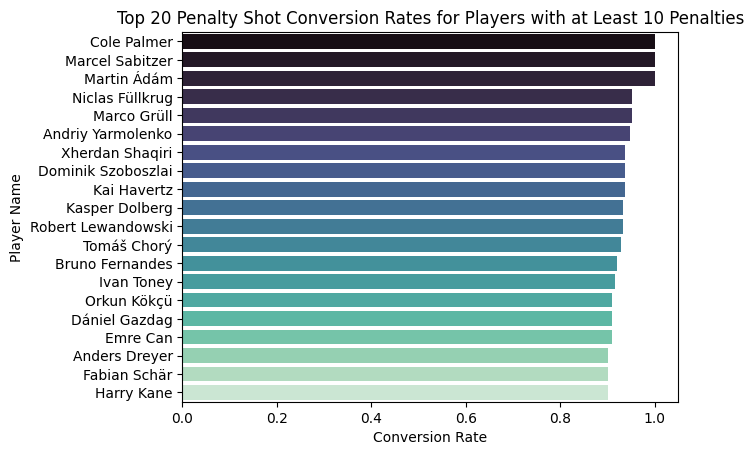

In [ ]:
import seaborn as sns



import pandas as pd

def calculate_conversion_rate(merged_df):
    conversion_rates = []

    for player_name, group_df in merged_df.groupby('Player Name'):
        total_shots = len(group_df)

        goal_shots = len(group_df[group_df['Outcome'] == 1])

        if total_shots >= 10:  # Only include players with at least 10 shots
            conversion_rate = goal_shots / total_shots
            conversion_rates.append({'Player Name': player_name, 'Total Shots': total_shots, 'Conversion Rate': conversion_rate})

    # Convert list of dictionaries to DataFrame
    conversion_rates_df = pd.DataFrame(conversion_rates)

    return conversion_rates_df

conversion_rates_df = calculate_conversion_rate(merged_df)

def draw_players_plot(dataframe):
    sns.barplot(y='Player Name', x='Conversion Rate', data=dataframe, palette="mako")
    plt.title('Top 20 Penalty Shot Conversion Rates for Players with at Least 10 Penalties')
    plt.xlabel('Conversion Rate')
    plt.ylabel('Player Name')
    plt.show()

# Sort the DataFrame by 'Conversion Rate' and take the top 20 players with the highest conversion rates
top_20_highest_conversion_rates_df = conversion_rates_df.sort_values('Conversion Rate', ascending=False).head(20)

draw_players_plot(top_20_highest_conversion_rates_df)

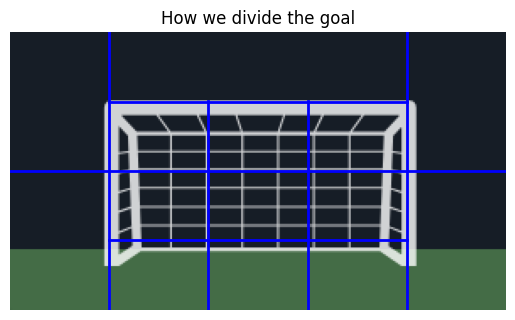

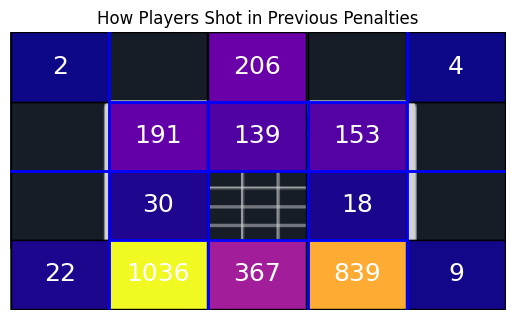

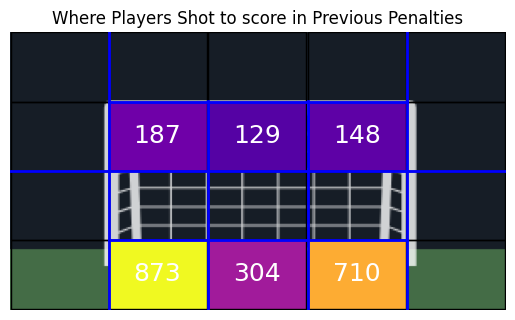

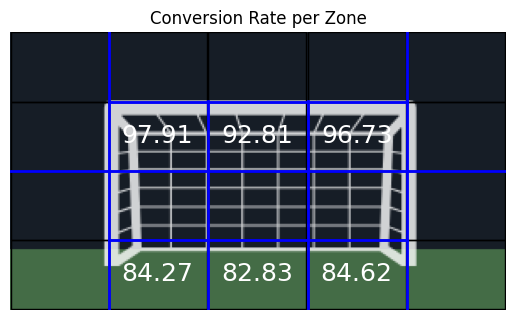

In [ ]:
zones_goal = merged_df[merged_df['Outcome']==1]['Zone'].value_counts()

zone_counts = merged_df['Zone'].value_counts()
zone_conversion_rate = (zones_goal / zone_counts) * 100




zone_conversion_rate = zone_conversion_rate.round(2)


cmap = plt.colormaps['plasma']
draw_goal_plot(zones,"How we divide the goal",None)
draw_goal_plot(zone_counts,"How Players Shot in Previous Penalties",cmap)
draw_goal_plot(zones_goal,"Where Players Shot to score in Previous Penalties",cmap)
draw_goal_plot(zone_conversion_rate,"Conversion Rate per Zone",cmap)



### K Nearest Neighbor


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

df = merged_df
label_encoders = {}
for column in ['Player Name', 'Tournament', 'Nationality', 'Club']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le
# Features and target
X = df[['Zone', 'X', 'Y','Position', 'Age', 'Caps', 'Goals']]
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Normalizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Applying k-NN algorithm
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.8147512864493996


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

from sklearn.multioutput import MultiOutputClassifier

# Features and targets
X = df[['X', 'Y', 'Position', 'Age', 'Caps', 'Goals']]
y = df[['Outcome', 'Zone']]

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Normalizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Applying k-NN algorithm
knn = KNeighborsClassifier(n_neighbors=3)
multi_target_knn = MultiOutputClassifier(knn, n_jobs=-1)
multi_target_knn.fit(X_train, y_train)
y_pred = multi_target_knn.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Train a Random Forest model for feature importance
rf = RandomForestClassifier(random_state=42)
multi_target_rf = MultiOutputClassifier(rf, n_jobs=-1)
multi_target_rf.fit(X_train, y_train)

# Extract feature importances
importances = multi_target_rf.estimators_[0].feature_importances_  # Example for the first target
feature_names = X.columns
indices = np.argsort(importances)[::-1]

# Print feature importances
print("Feature importances:")
for i in indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

# Visualize feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


ValueError: multiclass-multioutput is not supported